# A demo using Hydrogen Hamiltonian with GPT-QE.

In [2]:
import json, os, torch
from qwrapper.hamiltonian import compute_ground_state
from qwrapper.obs import PauliObservable
from gqe.mingpt.model import GPT
from gqe.mingpt.trainer import Trainer
from gqe.mingpt.utils import set_seed
from qswift.compiler import DefaultOperatorPool
from benchmark.molecule import DiatomicMolecularHamiltonian
from gqe.mingpt.cost import EnergyCost
from gqe.operator_pool.uccsd import UCCSD, generate_molecule
from gqe.common.initializer import HFStateInitializer

nqubit = 4
n_gates = 20
iter = 100
n_sample = 5
seed = 3047
distances = [0.5, 0.6, 0.7, 0.7414, 0.8, 0.9, 1.0, 1.5, 2.0]  # choices of the distance between two atoms
model_type = 'gpt2'
transformation = 'jordan-wigner'
is_bravyi = transformation == 'bravyi-kitaev'
MODEL_FILEBASE = '../saved_models/{}_model_h2_sto3g_{}_{}_{}.json'
ENERGY_FILEBASE = '../output/{}_energy_h2_sto3g_{}_{}_{}.txt'
OTHER_FILEBASE = '../output/{}_other_h2_sto3g_{}_{}_{}.json'

# Training

In [5]:

def find_ground_state_energy(distance, seed, ignore_cache=False):
    molecule = generate_molecule("H", "H", distance, "sto-3g", bravyi_kitaev=is_bravyi)
    set_seed(seed)
    # prepare file
    model_output = MODEL_FILEBASE.format(model_type, str(distance), transformation, seed)
    other_output = OTHER_FILEBASE.format(model_type, str(distance), transformation, seed)

    if not ignore_cache and os.path.exists(model_output):
        return

    # prepare Hamiltonian
    hamiltonian = DiatomicMolecularHamiltonian(nqubit, molecule, bravyi_kitaev=is_bravyi)

    ge = compute_ground_state(hamiltonian)
    print("ground state:", ge)

    # prepare operator_pool
    uccsd = UCCSD(4, molecule)
    paulis = uccsd.paulis
    paulis.append(PauliObservable("IIII"))
    initializer = HFStateInitializer(n_electrons=2)
    print("hf state:", hamiltonian.exact_value(initializer.init_circuit(4, [], "qulacs")))

    pool = DefaultOperatorPool(paulis)
    cost = EnergyCost(hamiltonian, initializer, pool,
                      [0.00625, -0.00625, 0.0125, -0.0125, 0.025, -0.025, 0.05, -0.05, 0.1, -0.1])

    model_config = GPT.get_default_config()
    model_config.model_type = model_type
    model_config.vocab_size = cost.vocab_size()
    model_config.block_size = cost.vocab_size()
    model_config.n_gates = n_gates  # The number of gates for each circuit
    model_config.temperature = 5  # Each gate is generated with probability exp(-temperature * logit)
    model_config.embd_pdrop = 0
    model_config.resid_pdrop = 0
    model_config.attn_pdrop = 0
    model = GPT(model_config, cost)

    # create a Trainer object

    train_config = Trainer.get_default_config()
    train_config.learning_rate = 5e-7  # the model we're using is so small that we can go a bit faster
    train_config.max_iters = iter
    train_config.num_workers = 0
    train_config.n_samples = n_sample

    trainer = Trainer(train_config, model)

    def batch_end_callback(trainer, detail):
        if trainer.iter_num % 1 == 0:
            print(
                f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f} temperature: {model.temperature}")
            model.temperature += 0.05
            print("mean_logits", torch.mean(detail.logits, 1) * model.energy_scaling)
            print("energies:", detail.energies)
            print("mean:", torch.mean(detail.energies))

    trainer.set_callback('on_batch_end', batch_end_callback)
    trainer.run()
    torch.save(model.state_dict(), model_output)

    model.temperature = 20
    indices, logits = model.generate(torch.zeros(10, 1, dtype=torch.int), model_config.n_gates)
    index = torch.argmin(cost.energy(indices)).item()
    target = indices.numpy()[index]
    computed_energy = cost.energy(torch.tensor([target])).item()

    m = {"distance": distance,
         "exact_energy": ge,
         "computed_energy": computed_energy,
         "n_gates": n_gates, "seed": seed}
    with open(other_output, "w") as f:
        f.write(json.dumps(m))


In [6]:
for d in distances:
    find_ground_state_energy(d, seed, ignore_cache=False)

converged SCF energy = -1.0429962745401
Starting to parse FermionOperator using 4 qubits...

Operator t:  0.379831351780953 [] +
-0.042217556922433806 [X0 X1 Y2 Y3] +
0.042217556922433806 [X0 Y1 Y2 X3] +
0.042217556922433806 [Y0 X1 X2 Y3] +
-0.042217556922433806 [Y0 Y1 X2 X3] +
0.21393531024521328 [Z0] +
0.17992650976405974 [Z0 Z1] +
0.13459240346368848 [Z0 Z2] +
0.17680996038612226 [Z0 Z3] +
0.2139353102452133 [Z1] +
0.17680996038612226 [Z1 Z2] +
0.13459240346368848 [Z1 Z3] +
-0.36914431524376606 [Z2] +
0.18620984259247156 [Z2 Z3] +
-0.369144315243766 [Z3]
Term, coeff:  () 0.379831351780953
Term, coeff:  ((0, 'Z'),) 0.21393531024521328
Index, p_char:  0 Z
Term, coeff:  ((1, 'Z'),) 0.2139353102452133
Index, p_char:  1 Z
Term, coeff:  ((2, 'Z'),) -0.36914431524376606
Index, p_char:  2 Z
Term, coeff:  ((3, 'Z'),) -0.369144315243766
Index, p_char:  3 Z
Term, coeff:  ((0, 'Z'), (1, 'Z')) 0.17992650976405974
Index, p_char:  0 Z
Index, p_char:  1 Z
Term, coeff:  ((0, 'Y'), (1, 'X'), (2, 'X')

# Figure

In [3]:
min_d = distances[0] - 0.1
max_d = distances[len(distances) - 1] + 0.1
n_bin = 100

xs = []
ys = []
ys3 = []
initializer = HFStateInitializer(n_electrons=2)
for j in range(n_bin):
    d = min_d + (max_d - min_d) / (n_bin - 1) * j
    molecule = generate_molecule("H", "H", d, "sto-3g", bravyi_kitaev=False)
    hamiltonian = DiatomicMolecularHamiltonian(nqubit, molecule, bravyi_kitaev=False)
    ge = compute_ground_state(hamiltonian)
    scf = hamiltonian.exact_value(initializer.init_circuit(4, [], "qulacs"))
    xs.append(d)
    ys.append(ge)
    ys3.append(scf)


converged SCF energy = -0.90436139416354
converged SCF energy = -0.936718704219097
converged SCF energy = -0.964945015121394
converged SCF energy = -0.989550091635695
converged SCF energy = -1.01096729731079
converged SCF energy = -1.02956727247755
converged SCF energy = -1.04566888041386
converged SCF energy = -1.05954801683135
converged SCF energy = -1.07144473111346
converged SCF energy = -1.08156900253999
converged SCF energy = -1.09010543818623
converged SCF energy = -1.09721710258265
converged SCF energy = -1.10304864664113
converged SCF energy = -1.10772887072515
converged SCF energy = -1.11137283126101
converged SCF energy = -1.11408358001426
converged SCF energy = -1.11595360874732
converged SCF energy = -1.1170660584989
converged SCF energy = -1.11749574153842
converged SCF energy = -1.11731001469769
converged SCF energy = -1.11656953494796
converged SCF energy = -1.1153289215404
converged SCF energy = -1.11363734358685
converged SCF energy = -1.11153904748242
converged SCF e

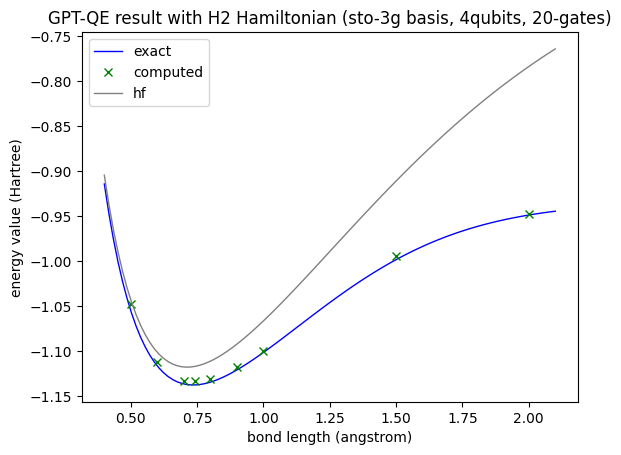

In [5]:
xs2 = []
ys2 = []

for d in distances:
    xs2.append(d)
    with open(OTHER_FILEBASE.format(model_type, d, transformation, seed)) as f:
        ys2.append(json.loads(f.readline())['computed_energy'])

import matplotlib.pyplot as p

# p.grid('-')
p.plot(xs, ys, label='exact', linewidth=1, color='blue')
p.plot(xs2, ys2, label='computed', marker='x', linewidth=0, color='green')
p.plot(xs, ys3, label='hf', linewidth=1, color='gray')
p.xlabel('bond length (angstrom)')
p.ylabel('energy value (Hartree)')
p.title('GPT-QE result with H2 Hamiltonian (sto-3g basis)')
p.legend()
p.show()